# Logistic Regression with amplpy
[![logistic_regression.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/amplcolab/blob/master/authors/glebbelov/conic/logistic_regression.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/amplcolab/blob/master/authors/glebbelov/conic/logistic_regression.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/amplcolab/blob/master/authors/glebbelov/conic/logistic_regression.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/amplcolab/blob/master/authors/glebbelov/conic/logistic_regression.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/amplcolab/blob/master/authors/glebbelov/conic/logistic_regression.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/amplcolab/blob/master/authors/glebbelov/conic/logistic_regression.ipynb)](https://colab.ampl.com)

Description: Logistic regression with amplpy

Tags: amplpy, regression, sigmoid, softplus, log-sum-exp, classifier, regularization, machine learning, conic, exponential cone, second-order cone, quadratic cone, formulation comparison

Notebook author: Gleb Belov <<gleb@ampl.com>>

References:
1. Example origins:
     https://docs.mosek.com/modeling-cookbook/expo.html#logistic-regression,
     https://docs.mosek.com/latest/pythonapi/case-studies-logistic.html#.
2. amplpy documentation: https://amplpy.readthedocs.io/.


In [1]:
# Install dependencies
!pip install -q amplpy pandas numpy matplotlib

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, tools
ampl = tools.ampl_notebook(
    modules=["coin", "mosek"], # modules to install
    license_uuid="default") # license to use

## The Data Set

We will implement regularized logistic regression to predict whether microchips from a fabrication plant pass quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly. Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected.

### Load example data into Pandas DataFrame



In [3]:
import pandas as pd
import numpy as np
qa = pd.read_csv(
    'logistic_regression_ex2data2.txt',
    names = ['Test1', 'Test2', 'Label']
)
display(qa.T)    # Transposed


,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
Test1,0.051267,-0.092742,-0.21371,-0.37500,-0.51325,-0.52477,-0.398040,-0.30588,0.016705,0.13191,...,-0.611180,-0.66302,-0.59965,-0.726380,-0.83007,-0.72062,-0.59389,-0.48445,-0.006336,0.632650
Test2,0.699560,0.684940,0.69225,0.50219,0.46564,0.20980,0.034357,-0.19225,-0.404240,-0.51389,...,-0.067982,-0.21418,-0.41886,-0.082602,0.31213,0.53874,0.49488,0.99927,0.999270,-0.030612
Label,1.000000,1.000000,1.00000,1.00000,1.00000,1.00000,1.000000,1.00000,1.000000,1.00000,...,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000


### Visualize data

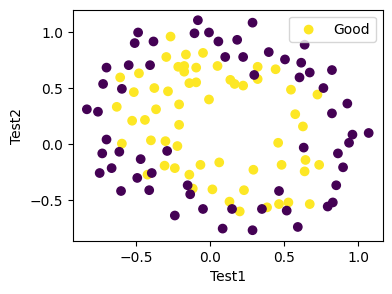

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(x=qa['Test1'], y=qa['Test2'], c=qa['Label'], label='Good')
ax.set_xlabel("Test1")
ax.set_ylabel("Test2")
ax.legend()
plt.show()

### Lift the 2D data

Logistic regression is an example of a binary classifier, where the output takes one of the two values 0 or 1 for each data point. We call the two values *classes*.

As we see from the plot, a linear separation of the classes is not reasonable. We lift the 2D data into $\mathbf{R}^{28}$ via sums of monomials of degrees up to 6.


In [5]:
def LiftToDegree(x, y, deg):
    result = pd.DataFrame()
    for i in range(deg+1):
        for j in range(i+1):
            temp = x**i + y**(i-j)
            result["V{}{}".format(i, i-j)] = temp
    return result

In [6]:
degree_lift = 6
new_data = LiftToDegree(qa['Test1'], qa['Test2'], degree_lift)
display(new_data)

,V00,V11,V10,V22,V21,V20,V33,V32,V31,V30,...,V52,V51,V50,V66,V65,V64,V63,V62,V61,V60
0,2.0,0.750827,1.051267,0.492012,0.702188,1.002628,0.342488,0.489519,0.699695,1.000135,...,0.489385,0.699560,1.000000,0.117206,0.167542,0.239497,0.342354,0.489384,0.699560,1.000000
1,2.0,0.592198,0.907258,0.477744,0.693541,1.008601,0.320537,0.468345,0.684142,0.999202,...,0.469136,0.684933,0.999993,0.103257,0.150752,0.220096,0.321335,0.469143,0.684941,1.000001
2,2.0,0.478540,0.786290,0.524882,0.737922,1.045672,0.321973,0.469450,0.682489,0.990239,...,0.478764,0.691804,0.999554,0.110142,0.159065,0.229738,0.331828,0.479305,0.692345,1.000095
3,2.0,0.127190,0.625000,0.392820,0.642815,1.140625,0.073915,0.199460,0.449456,0.947266,...,0.244779,0.494774,0.992584,0.018821,0.034721,0.066383,0.129431,0.254976,0.504971,1.002781
4,2.0,-0.047610,0.486750,0.480246,0.729066,1.263426,-0.034243,0.081617,0.330437,0.864797,...,0.181205,0.430024,0.964384,0.028473,0.040170,0.065291,0.119240,0.235101,0.483920,1.018280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,2.0,-0.181880,0.279380,0.809534,1.058033,1.519293,-0.217849,-0.083972,0.164527,0.625787,...,0.095914,0.344414,0.805674,0.164485,0.185419,0.224275,0.296400,0.430276,0.678775,1.140035
114,2.0,-0.099010,0.406110,0.597612,0.847585,1.352705,-0.088269,0.035438,0.285412,0.790532,...,0.171026,0.420999,0.926119,0.058566,0.073559,0.103856,0.165076,0.288783,0.538757,1.043877
115,2.0,0.514820,0.515550,1.233232,1.233962,1.234692,0.884115,0.884844,0.885574,0.886304,...,0.971857,0.972586,0.973316,1.008555,1.009282,1.010010,1.010738,1.011467,1.012197,1.012927
116,2.0,0.992934,0.993664,0.998581,0.999310,1.000040,0.997811,0.998540,0.999270,1.000000,...,0.998541,0.999270,1.000000,0.995628,0.996355,0.997083,0.997812,0.998541,0.999270,1.000000


## Modeling in AMPL

### Formulation as a convex optimization problem

Define the sigmoid function

$$S(x)=\frac{1}{1+e^{-x}}.$$

Next, given an observation $x\in\mathbf{R}^d$ and weights $\theta\in\mathbf{R}^d$ we set

$$ h_\theta(x)=S(\theta^Tx)=\frac{1}{1+e^{-\theta^Tx}}.$$

The weights vector $\theta$ is part of the setup of the classifier. The expression 
$h_\theta(x)$ is interpreted as the probability that $x$ belongs to class 1.
When asked to classify $x$ the returned answer is

$$ \begin{split}x\mapsto \begin{cases}\begin{array}{ll}1, & h_\theta(x)\geq 1/2, \\ 0, & h_\theta(x) < 1/2.\end{array}\end{cases}\end{split}$$

When training a logistic regression algorithm we are given a sequence of training examples $x_i$, each labelled with its class $y_i\in \{0,1\}$ and we seek to find the weights
$\theta$ which maximize the likelihood function

$$\textstyle \prod_i h_\theta(x_i)^{y_i}(1-h_\theta(x_i))^{1-y_i}.$$

Of course every single $y_i$ equals 0 or 1, so just one factor appears in the product for each training data point. By taking logarithms we can define the logistic loss function:

$$ J(\theta) = -\sum_{i:y_i=1} \log(h_\theta(x_i))-\sum_{i:y_i=0}\log(1-h_\theta(x_i)). $$

The training problem with regularization (a standard technique to prevent overfitting) is now equivalent to

$$ \min_\theta J(\theta) + \lambda\|\theta\|_2. $$

This formulation can be solved with a general nonlinear solver, such as Ipopt.

In [7]:
%%writefile logistic_regression.mod

set POINTS;
set DIMS;                  # Dimensionality of x

param y{POINTS} binary;    # Points' classes
param x{POINTS, DIMS};
param lambd;               # Regularization parameter

var theta{DIMS};           # Regression parameter vector
var hTheta{i in POINTS}
    = 1 / (1 + exp( - sum{d in DIMS} theta[d]*x[i, d] ));

minimize Logit:            # General nonlinear formulation
    - sum {i in POINTS: y[i] >0.5} log( hTheta[i] )
    - sum {i in POINTS: y[i]<=0.5} log( 1.0 - hTheta[i] )
    + lambd * sqrt( sum {d in DIMS} theta[d]^2 );


Overwriting logistic_regression.mod


### Formulation as a conic program

For a conic solver such as Mosek, we need to reformulate the problem.

The objective function can equivalently be phrased as

$$
\begin{split}\begin{array}{lrllr}
\min & \sum_i t_i +\lambda r  \\
\text{s.t.} & t_i      & \geq - \log(h_\theta(x))   & = \log(1+e^{-\theta^Tx_i}) & \mathrm{if}\ y_i=1, \\
         & t_i      & \geq - \log(1-h_\theta(x)) & = \log(1+e^{\theta^Tx_i})  & \mathrm{if}\ y_i=0, \\
         & r        & \geq \|\theta\|_2.
\end{array}\end{split}
$$

The key point is to implement the [softplus bound](https://docs.mosek.com/modeling-cookbook/expo.html#softplus-function) $t\geq \log(1+e^u)$, which is the simplest example of a log-sum-exp constraint for two terms. Here $t$ is a scalar variable and $u$ will be the affine expression of the form $\pm \theta^Tx_i$. This is equivalent to

$$
e^{u-t} + e^{-t} \leq 1
$$

and further to

$$
\begin{split}\begin{array}{rclr}
z_1  & \ge  & e^{u-t}, \\
z_2  & \ge  & e^{-t}, \\
z_1+z_2       & \leq & 1.
\end{array}\end{split}
$$


In [8]:
%%writefile logistic_regression_conic.mod

set POINTS;
set DIMS;                  # Dimensionality of x

param y{POINTS} binary;    # Points' classes
param x{POINTS, DIMS};
param lambd;               # Regularization parameter

var theta{DIMS};           # Regression parameter vector
var t{POINTS};
var u{POINTS};
var v{POINTS};
var r >= 0;

minimize LogitConic:
    sum {i in POINTS} t[i] + lambd * r;
    
s.t. Softplus1{i in POINTS}:  # reformulation of softplus
    u[i] + v[i] <= 1;
s.t. Softplus2{i in POINTS}:
    u[i] >= exp(
        (if y[i]>0.5 then     # y[i]==1
            -sum {d in DIMS} theta[d] * x[i, d]
         else
            sum {d in DIMS} theta[d] * x[i, d]
        ) - t[i]
    );
s.t. Softplus3{i in POINTS}:
    v[i] >= exp(-t[i]);
    
s.t. Norm_Theta:              # Quadratic cone for regularizer
    r^2 >= sum {d in DIMS} theta[d]^2;


Overwriting logistic_regression_conic.mod


### Load data directly from Python data structures using [amplpy](https://amplpy.readthedocs.io/)

In [9]:
import time

def LogitRegression(label, new_data, lambd, \
                    modfile="logistic_regression_conic.mod",
                    solver="ipopt"):

    # Create AMPL instance and load the model
    ampl = AMPL()
    ampl.read(modfile)

    # load the data
    ampl.set["POINTS"] = list(new_data.index)
    ampl.set["DIMS"] = list(new_data.columns)
    
    ampl.param["y"] = list(label)
    ampl.param["x"] = new_data.T.unstack(1)
    ampl.param["lambd"] = lambd

    # solve
    ampl.option["solver"] = solver  # mosek, ipopt, knitro
    ampl.eval("let{d in DIMS} theta[d] := 0.0001;") # initial guesses for IPOPT
    tm = time.perf_counter()
    ampl.solve()
    tm = time.perf_counter() - tm

    # return solution and solve time
    return \
        ampl.get_variable('theta').get_values().to_pandas(), \
        tm


### Solve with Mosek

In [10]:
def PlotRegression(qa, lambd, theta, ax):
    x=qa['Test1']
    y=qa['Test2']
    # c = ( 1/(1 + np.exp(-theta.T @ new_data.T)) > 0.5 )
    c=qa['Label']
    ax.scatter(x, y, c=c, label='Good')
    x0, y0, x1, y1 = min(x), min(y), max(x), max(y)
    xd = (x1-x0)/10
    yd = (y1-y0)/10
    xr = np.linspace(x0-xd, x1+xd, 500)
    yr = np.linspace(y0-xd, y1+xd, 500)
    X, Y = np.meshgrid(xr, yr)                # grid of points
    X1 = np.reshape(X, (500*500))
    Y1 = np.reshape(Y, (500*500))
    X1Y1lft = LiftToDegree(X1, Y1, degree_lift)
    theta_by_X1Y1 = theta.T @ X1Y1lft.T
    theta_by_XY = np.reshape(theta_by_X1Y1, (500, 500))
    Z = np.zeros_like(X)
    for i in range(500):
        for j in range(500):
            Z[i,j] = 1 if 1/(1 + np.exp(-theta_by_XY[i, j])) > 0.5 else 0

    cp = ax.contour(X, Y, Z)
    ax.set_title('lambda = {}'.format(lambd))

In [11]:
def SolveAndSubplot(qa, new_data, lambd, ax, mdl, slv):
    theta, tm = LogitRegression(qa["Label"], new_data, lambd, mdl, slv)
    PlotRegression(qa, lambd, theta, ax)
    display(theta.T)
    return tm

In [12]:
def BenchmarkLambda(modfile, solver):
    fig, ax = plt.subplots(2, 2, figsize=(9, 7))

    tm =  SolveAndSubplot(qa, new_data, 0, ax[0, 0], modfile, solver)
    tm += SolveAndSubplot(qa, new_data, 0.1, ax[0, 1], modfile, solver)
    tm += SolveAndSubplot(qa, new_data, 1, ax[1, 0], modfile, solver)
    tm += SolveAndSubplot(qa, new_data, 10, ax[1, 1], modfile, solver)

    plt.show()
    return \
        f"Solving time for model '{modfile}' with solver '{solver}':  {tm:.2f} sec"

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      406

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

,V00,V10,V11,V20,V21,V22,V30,V31,V32,V33,...,V53,V54,V55,V60,V61,V62,V63,V64,V65,V66
theta.val,15.523301,-3.633966,2.590589,-8.126939,-1.902384,-3.989014,1.928339,8.152895,6.066265,-6.723648,...,-19.5182,-2.122613,40.624288,-13.317736,-7.09318,-9.179811,-21.969723,-4.574136,38.172765,-49.556488


Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      406

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

,V00,V10,V11,V20,V21,V22,V30,V31,V32,V33,...,V53,V54,V55,V60,V61,V62,V63,V64,V65,V66
theta.val,5.401532,-1.07786,0.95349,-2.283455,-0.252105,-1.560747,1.097504,3.128854,1.820212,-0.267757,...,-3.186999,-2.070882,5.470523,-2.820791,-0.78944,-2.098083,-4.186052,-3.069935,4.47147,-0.429828


Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      406

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

,V00,V10,V11,V20,V21,V22,V30,V31,V32,V33,...,V53,V54,V55,V60,V61,V62,V63,V64,V65,V66
theta.val,2.231634,-0.068601,0.640099,-1.301816,-0.593116,-1.771264,0.365495,1.074196,-0.103952,0.128679,...,-0.010955,-0.272733,0.334397,-0.315511,0.393189,-0.784959,-0.552328,-0.814106,-0.206975,-0.499913


Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      406

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

,V00,V10,V11,V20,V21,V22,V30,V31,V32,V33,...,V53,V54,V55,V60,V61,V62,V63,V64,V65,V66
theta.val,0.402155,0.096959,0.213092,-0.199167,-0.083033,-0.452255,0.114077,0.23021,-0.139012,-0.018108,...,-0.035393,-0.184988,-0.10975,-0.013748,0.102385,-0.266837,-0.145933,-0.295528,-0.22029,-0.291594


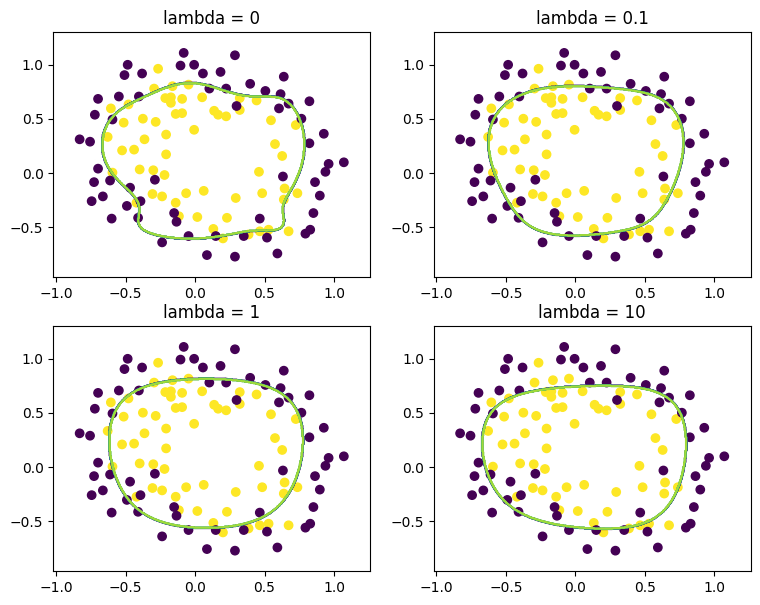

In [13]:
res1 = BenchmarkLambda("logistic_regression.mod", "ipopt")

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4041
Number of nonzeros in Lagrangian Hessian.............:     3829

Total number of variables............................:      383
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

,V00,V10,V11,V20,V21,V22,V30,V31,V32,V33,...,V53,V54,V55,V60,V61,V62,V63,V64,V65,V66
theta.val,15.523301,-3.633967,2.590589,-8.12694,-1.902384,-3.989014,1.928339,8.152895,6.066265,-6.723648,...,-19.5182,-2.122613,40.624289,-13.317736,-7.09318,-9.17981,-21.969723,-4.574135,38.172767,-49.55649


Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4041
Number of nonzeros in Lagrangian Hessian.............:     3829

Total number of variables............................:      383
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

,V00,V10,V11,V20,V21,V22,V30,V31,V32,V33,...,V53,V54,V55,V60,V61,V62,V63,V64,V65,V66
theta.val,5.401532,-1.07786,0.95349,-2.283455,-0.252105,-1.560747,1.097504,3.128854,1.820212,-0.267757,...,-3.186999,-2.070882,5.470523,-2.820791,-0.78944,-2.098083,-4.186052,-3.069935,4.47147,-0.429828


Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4041
Number of nonzeros in Lagrangian Hessian.............:     3829

Total number of variables............................:      383
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

,V00,V10,V11,V20,V21,V22,V30,V31,V32,V33,...,V53,V54,V55,V60,V61,V62,V63,V64,V65,V66
theta.val,2.231634,-0.068601,0.640099,-1.301816,-0.593116,-1.771264,0.365495,1.074196,-0.103952,0.128679,...,-0.010955,-0.272733,0.334397,-0.315511,0.393189,-0.784959,-0.552328,-0.814106,-0.206975,-0.499913


Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4041
Number of nonzeros in Lagrangian Hessian.............:     3829

Total number of variables............................:      383
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

,V00,V10,V11,V20,V21,V22,V30,V31,V32,V33,...,V53,V54,V55,V60,V61,V62,V63,V64,V65,V66
theta.val,0.402155,0.096959,0.213092,-0.199167,-0.083033,-0.452255,0.114077,0.23021,-0.139012,-0.018108,...,-0.035393,-0.184988,-0.10975,-0.013748,0.102385,-0.266837,-0.145933,-0.295528,-0.22029,-0.291594


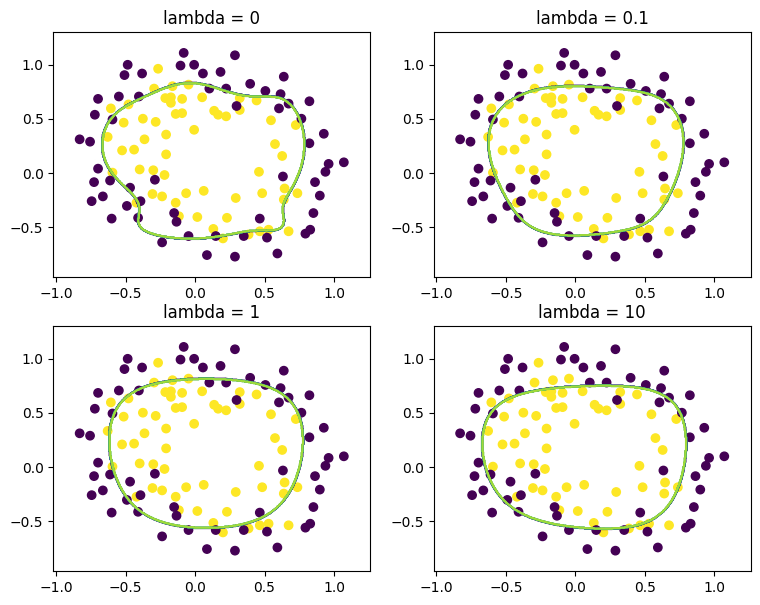

In [14]:
res2 = BenchmarkLambda("logistic_regression_conic.mod", "ipopt")

MOSEK 10.0.43: MOSEK 10.0.43: optimal, stalling; objective 45.98543739
0 simplex iterations
17 barrier iterations


,V00,V10,V11,V20,V21,V22,V30,V31,V32,V33,...,V53,V54,V55,V60,V61,V62,V63,V64,V65,V66
theta.val,15.523221,-3.633944,2.590569,-8.126913,-1.90237,-3.988992,1.92835,8.15287,6.066243,-6.723619,...,-19.518126,-2.122616,40.624116,-13.317645,-7.093121,-9.17976,-21.969618,-4.574111,38.172625,-49.556238


MOSEK 10.0.43: MOSEK 10.0.43: optimal; objective 49.1663679
0 simplex iterations
11 barrier iterations


,V00,V10,V11,V20,V21,V22,V30,V31,V32,V33,...,V53,V54,V55,V60,V61,V62,V63,V64,V65,V66
theta.val,5.401486,-1.077848,0.953484,-2.283445,-0.252112,-1.560754,1.097501,3.128834,1.820192,-0.267762,...,-3.186975,-2.070868,5.470486,-2.820757,-0.789424,-2.098066,-4.18602,-3.069914,4.471441,-0.429814


MOSEK 10.0.43: MOSEK 10.0.43: optimal; objective 54.44427897
0 simplex iterations
9 barrier iterations


,V00,V10,V11,V20,V21,V22,V30,V31,V32,V33,...,V53,V54,V55,V60,V61,V62,V63,V64,V65,V66
theta.val,2.231584,-0.068598,0.640087,-1.301789,-0.593105,-1.771228,0.365485,1.074169,-0.103955,0.128671,...,-0.010958,-0.272724,0.334394,-0.315501,0.393183,-0.784941,-0.552315,-0.814082,-0.206963,-0.499895


MOSEK 10.0.43: MOSEK 10.0.43: optimal; objective 75.51578906
0 simplex iterations
15 barrier iterations


,V00,V10,V11,V20,V21,V22,V30,V31,V32,V33,...,V53,V54,V55,V60,V61,V62,V63,V64,V65,V66
theta.val,0.40215,0.096959,0.213088,-0.199158,-0.083029,-0.452247,0.114074,0.230203,-0.139015,-0.018114,...,-0.035399,-0.184991,-0.109754,-0.013747,0.102382,-0.266836,-0.145935,-0.295527,-0.220291,-0.291593


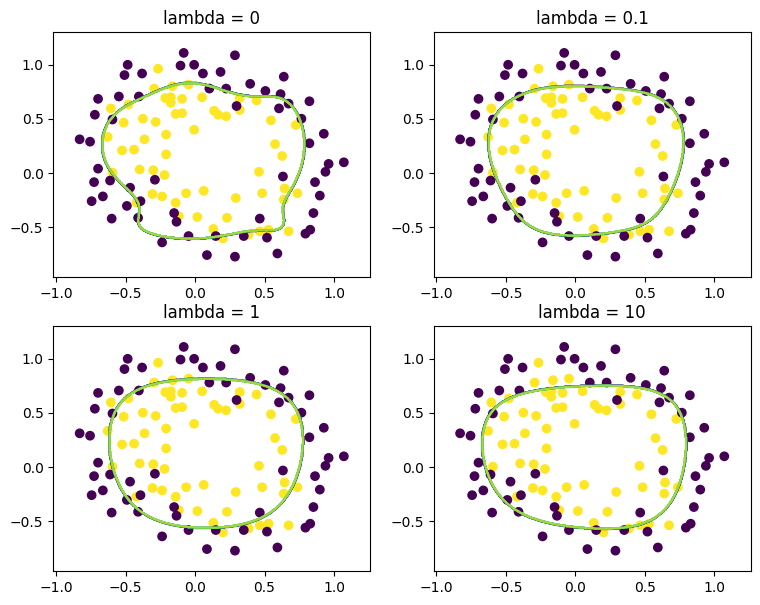

In [15]:
res3 = BenchmarkLambda("logistic_regression_conic.mod", "mosek")

In [16]:
display(res1)
display(res2)
display(res3)

"Solving time for model 'logistic_regression.mod' with solver 'ipopt':  0.08 sec"

"Solving time for model 'logistic_regression_conic.mod' with solver 'ipopt':  1.73 sec"

"Solving time for model 'logistic_regression_conic.mod' with solver 'mosek':  0.28 sec"

### Discussion

Logistic regression can be modeled as a convex nonlinear optimization problem.

We considered an example with none, medium and strong regularization (small, medium, large lambda). Without regularization we get obvious overfitting.

The general nonlinear formulation seems to work best overall. When a conic formulation is required, a conic solver is faster.